<a href="https://colab.research.google.com/github/brooke57/BrainTumorImageClassification/blob/main/Final_Binary_Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Binary Brain Tumor Classification**

## **Technical Summary**

Throughout this convolutional neural network modeling process, many different iterations were run. A simple convolutional neural network with no adjustments or regularization served as the baseline, and subsequent iterations of this baseline attempted to improve the networks performance by adding dropout layers, using Batch Normalization, accounting for class imbalance, using padding, etc. For each dense layer in every model iteration, the relu activation function was used, due to its tendency to prevent activation of all the neurons in a layer at a time, which often yields better results. For the final output layer, the sigmoid function was used, since this is a binary classification problem. Some of these adjustments made in the iterations helped more than others, but the network was still not performing optimally, and there was constantly an overfitting problem. Next, the pretrained VGG-19 neural network was implemented, which showed much improvement in model performance. After trying a few different iterations using this pretrained neural network, which varied in dropout layer inclusion/placement, and if/what outer layers of pretrained network were unfrozen and available to learn from this dataset's images. In the end, the iteration (called "Incorporating Class Weights into Pretrained VGG-19 (Final Model)" which yielded the best results was a pretrained VGG-19 network accounting for class weights (giving the minority class of "no tumor" images a weight of three) with a flatten layer and two dense layers on top, with all of the VGG-19 layers frozen. This model iteration had a validation accuracy of 97%, a loss of 7%, recall of 100%, and a precision of 97%.

## **Business Understanding**

The organization *Doctors without Borders* is constantly seeking to improve healthcare in developing nations. Artificial Intelligence could greatly assist them in these efforts, by assisting Doctors in the diagnosis of brain tumors. For the diagnosis of a brain tumor, a neurosurgeon is required to make the diagnoses from looking at the MRI, and in third world countries seasoned neurosurgeons are somewhat rare. A machine learning tool which could distinguish between normal and tumorous brain MRIs, thereby flagging those with tumors for further analysis and classification of tumor type by a qualified doctor, would be of great value to *Doctors without Borders* as they seek to improve healthcare in developing countries. In a developing nation with fewer seasoned neurosurgeons, where other types of doctors have to step in who may still be learning to detect and diagnose tumors from an MRI, this would be especially valuable. Having doctors use this machine learning model as a supplemental tool could help speed up tumor detection and accuracy. Additionally, using this model could potentially cut down on the physician time required to analyze patient scans.  

When evaluating this problem, there are two types of errors that can occur when using computational models to diagnose the presence of a brain tumor; a type 1 error and a type II error. A type 1 error occurs when the model identifies an MRI scan as having a brain tumor when it is normal, and a type II error occurs when the model identifies an MRI scan with a tumor in it as a normal, tumor free scan. To minimize type I errors, it is necessary to maximize precision. To minimize type II errors, it is necessary to maximize recall. While it is the ultimate goal to maximize both precision and recall, thereby minimizing both types of error, if it isn't possible to mximize both metrics, it is more important to maximize recall. If the model thinks that an image contains a tumor and it doesn't, then the doctor and patient become concerned when they don't need to be. This is not desirable, but no one's long term health is damaged. On the other hand, if the model fails to identify a tumor in an image that does contain a tumor, then neither the doctor nor patient are alerted of ths fact, and the patient does not get treatment, and the tumor would continue to negatively impact their health. Because this consequence is worse, recall scores will be more important to maximize.

## **Data Understanding**

This data is composed of a series of Brain MRIs consisting of scans which contain a tumor and those that do not. The data actually comes from an existing kaggle dataset ("Brain Tumor Classification (MRI)"), which further divided the tumor data into three different types: Glioma, Meningioma, and Pituitary. I downloaded this data and combined all the tumor scans into one category and then uploaded it onto kaggle, so that I could make this a binary classification question. There are a variety of different planes, or perspectives, from which the scans are taken; some are sagital scans (plane that shows the side of the brain), some are coronal scans (plane that shows the back of the brain, at varying depths), and some are transverse (plane that shows the top of the brain, at varying depths; like a bird's eye view). The dataset contains MRIs taken with a variety of different methods, namely T1, T2, and FLAIR. Each of these different methods results in an MRI image with varying levels of brightness and contrast. The data contains 2,764 tumor MRIs and 500 normal MRIs, so the dataset is very imbalanced. Each image uses all three color channels, and each is a different size, so I standardized all images to be 200 x 200 x 3.

In [ ]:
# Getting environment info (output cleared to save space, but saved in a file called "Environment_Requirements")
! pip freeze

In [1]:
# Set random state for numpy operations
from numpy.random import seed
seed(2)
# Set random state for tensorflow operations
from tensorflow.random import set_seed
set_seed(3)
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix
import cv2
import PIL
import matplotlib.image as mpimg

## **Functions**

In [12]:
# Defining a function that will freeze all layers in a pretrained and original network
# Code structure from https://github.com/learn-co-curriculum/dsc-using-pretrained-networks-codealong
def Freeze_Pretrained_Base(pretrain, model):
    
    '''This function will freeze all layers in a pretrained and original network
      pretrain: refers to any instantiated pretrained network
      model: the name of the model you are adding the pretrained network to
    '''
    pretrain.trainable = False
    for layer in model.layers:
        print(layer.name, layer.trainable)
    print(len(model.trainable_weights))

In [14]:
# Re-freezing everything except for the last layer of the pretrained CNN
# Code structure from https://github.com/learn-co-curriculum/dsc-using-pretrained-networks-codealong
def Unfreeze_Layers(pretrain, layer_list):
    '''This function takes an instantiated pretrained neural network and a list containing layers to be frozen,
    and freezes those layers in the pretrained neural network.
    
    pretrain: refers to the instantiated pretrained neural network
    layer_list: refers to the list of layers to be frozen in the instantiated pretrained neural network.'''

    pretrain.trainable = True
    for layer in  pretrain.layers:
        if layer.name in layer_list:
            layer.trainable = True
        else:
            layer.trainable = False
        
    for layer in pretrain.layers:
        print(layer.name, layer.trainable)
    print(len(pretrain.trainable_weights))

In [4]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [5]:
def print_metrics(saved_model_name, generator, test_or_val):

  superior_model = load_model(saved_model_name)
  final_scores = superior_model.evaluate_generator(generator)
  metrics = ['Loss', 'Accuracy', 'Recall', 'Precision', 'True Positives', 'True Negatives', 'False Positives', 'False Negatives' ]
  
  for i, metric in enumerate(metrics):
    print(test_or_val+' '+ metric + ':', final_scores[i])

In [6]:
# I modified this function slightly from the one found on: 
# https://github.com/austint1121/OES-PneumoniaClassification/blob/main/Final_Notebook.ipynb

def network_matrix(model_scores):
    """
    Plots a confusion matrix using the scores that come from evaluating a 
    neural network model using either testing or validation data
   
  
    Parameters:
    model_scores = load_model('model_name.h5').evaluate_generator(test/val_generator) 
  
    Returns:
    confusion matrix
    """
    tn = np.round((model_scores[5])/(model_scores[5] + model_scores[6]), 2)
    fn = np.round((model_scores[7])/(model_scores[7] + model_scores[4]), 2)
    fp = np.round((model_scores[6])/(model_scores[6] + model_scores[5]), 2)
    tp = np.round((model_scores[4])/(model_scores[4] + model_scores[7]), 2)
    
    
    conf = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots(figsize=(10, 8))
    heat = sns.heatmap(conf, annot=True, fmt='g', ax=ax )
    heat.set_xticklabels(['Brain Tumor', 'Normal'], fontsize=15)
    heat.set_yticklabels(['Brain Tumor', 'Normal'], fontsize=15)
    plt.ylabel('Predicted Label',fontsize=18)
    plt.xlabel('True Label', fontsize=18)

In [7]:
def print_metrics_confusionmatrix(saved_model_name, generator, test_or_val):

  superior_model = load_model(saved_model_name)
  final_scores = superior_model.evaluate_generator(generator)
  network_matrix(final_scores)
  metrics = ['Loss', 'Accuracy', 'Recall', 'Precision', 'True Positives', 'True Negatives', 'False Positives', 'False Negatives' ]
  
  for i, metric in enumerate(metrics):
    print(test_or_val+' '+ metric + ':', final_scores[i])

## **Data Retrieval and Loading**

First, I loaded data that I downloaded from kaggle onto my google drive account. Then I followed instructions from [this blog](https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e) to load the data into this google colab notebook.

In [2]:
# Retrieve the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
#Import libraries
import zipfile
import os
# Load the data
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Brain_MRI_Tumor_Images.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') # Takes out files and puts them into the /tmp folder
zip_ref.close()

In [4]:
# Specify the train and test file paths
base_direc = '/tmp/Brain_MRI_Tumor_Images'
train_direc = os.path.join(base_direc, 'Training')
test_direc = os.path.join(base_direc, 'Testing')

## **Taking a Look at a Few Different Individual Images**

In [34]:
images = ['/tmp/Brain_MRI_Tumor_Images/Training/no_tumor_train/image (11).jpg',
         '/tmp/Brain_MRI_Tumor_Images/Training/no_tumor_train/image(115).jpg',
         '/tmp/Brain_MRI_Tumor_Images/Training/no_tumor_train/image(108).jpg',
         '/tmp/Brain_MRI_Tumor_Images/Training/no_tumor_train/image(100).jpg',
         '/tmp/Brain_MRI_Tumor_Images/Training/no_tumor_train/image(132).jpg',
         '/tmp/Brain_MRI_Tumor_Images/Training/no_tumor_train/image(145).jpg',
         '/tmp/Brain_MRI_Tumor_Images/Training/AllTumorsTrain/gg (105).jpg',
         '/tmp/Brain_MRI_Tumor_Images/Training/AllTumorsTrain/gg (12).jpg',
         '/tmp/Brain_MRI_Tumor_Images/Training/AllTumorsTrain/m (126).jpg',
         '/tmp/Brain_MRI_Tumor_Images/Training/AllTumorsTrain/m (130).jpg',
         '/tmp/Brain_MRI_Tumor_Images/Training/AllTumorsTrain/p (471).jpg',
         '/tmp/Brain_MRI_Tumor_Images/Training/AllTumorsTrain/p (490).jpg']

In [35]:
shapes = []
for i in images:
  img = mpimg.imread(i)
  shapes.append(img.shape)
shapes

[(198, 254, 3),
 (243, 236, 3),
 (251, 201, 3),
 (239, 236, 3),
 (251, 447, 3),
 (236, 236, 3),
 (512, 512, 3),
 (512, 512, 3),
 (512, 512, 3),
 (512, 512, 3),
 (512, 512, 3),
 (256, 256, 3)]

The images are all different shapes, and use three color channels. The sizes of the images will need to be standardized.

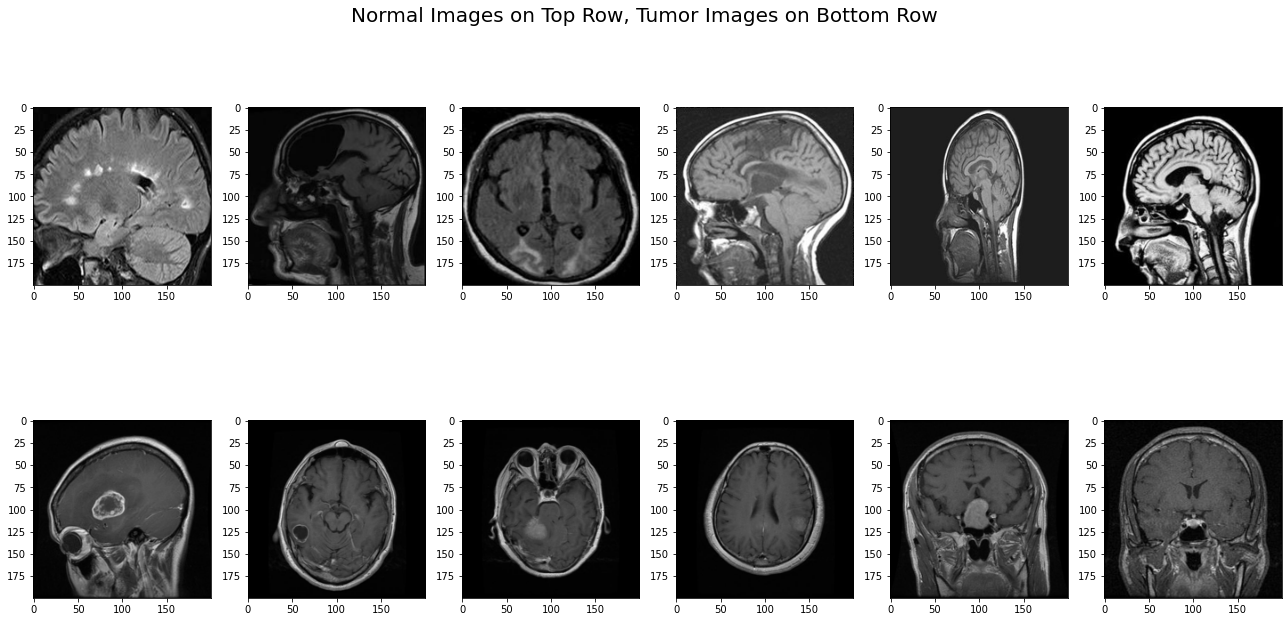

In [ ]:
# Some of code structure from https://stackoverflow.com/questions/48435229/how-to-plot-a-list-of-image-in-loop-using-matplotlib/48435411
fig, axes = plt.subplots(2, 6, figsize=(18, 10))
rows = 2

for num, x in enumerate(images):
    img = PIL.Image.open(x)
    re_img = img.resize((200,200))
    ax = axes[num // 6, num % 6]
    ax.imshow(re_img)
    

fig.suptitle('Normal Images on Top Row, Tumor Images on Bottom Row', fontsize=20)
plt.tight_layout()
plt.show()

## **Data Preparation**

In [ ]:
# Code structure from https://github.com/austint1121/OES-PneumoniaClassification/blob/main/Final_Notebook.ipynb
# Set up ImageDataGenerator
train_imagegen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   zoom_range=([0.6,1]),
                                   rotation_range=10,                           
                                   brightness_range=([0.6, 1.5]),
                                   horizontal_flip=True,
                                   validation_split=0.06) # this will set aside a part of training set for validation data
test_imagegen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   zoom_range=([0.6,1]),
                                   rotation_range=10,
                                   brightness_range=([0.6,1.5]),
                                   horizontal_flip=True)
# Bring the data in
train_generator = train_imagegen.flow_from_directory(
                                    train_direc,
                                    classes={'no_tumor_train':0,
                                            'AllTumorsTrain':1},
                                    target_size=(200,200),
                                    batch_size=2699, # Number of images in training set
                                    seed=42,
                                    class_mode='binary',
                                    subset='training')

test_generator = test_imagegen.flow_from_directory(
                                    test_direc,
                                     classes={'no_tumor_test':0,
                                            'AllTumorsTest':1},
                                    target_size=(200,200),
                                    batch_size=394, # Number of images in testing set
                                    seed=42,
                                    class_mode='binary')

val_generator = train_imagegen.flow_from_directory(
                                    train_direc,
                                     classes={'no_tumor_train':0,
                                            'AllTumorsTrain':1},
                                    target_size=(200,200),
                                    batch_size=171, # Number of images in validation set
                                    seed=42,
                                    class_mode='binary',
                                    subset='validation')

Found 2699 images belonging to 2 classes.
Found 394 images belonging to 2 classes.
Found 171 images belonging to 2 classes.


In [ ]:
# Creating variables to contain image vectors and labels for training images
train_img, train_lab = next(train_generator)

In [ ]:
# Creating variables to contain image vectors and labels for testing images
test_img, test_lab = next(test_generator)

In [ ]:
# Creating variables to contain image vectors and labels for validation images
val_img, val_lab = next(val_generator)

**Important Notes**

One important thing to note is that throughout the modelling process, I use train_generator as my training data images, and testing_generator as my testing set which I use every time I run a model to asses overfitting. Val_generator data is used only once on the final model, to asses how well the model does on data is has never seen before. This clarification is important because for every model that is run, all of the epochs are printed out, and the metrics/results for testing data are referred to as 'val.' Unless otherwise specified, any metric starting with 'val' in the epich print outs is really testing data.

Additionally, I wanted to clarify a few phrases that I use frequently in my model analyses. When I refer to "the last epoch" and mention the scores for this particular epoch, this is because the weights of the last epoch are the weights that will be stored in the model, should it be used for further analysis, so it is the scores from this epoch that are most relevant for analysis.

In the models where I use early stopping and model checkpoint, I use the phrase "in the epoch with the lowest testing loss" and mention scores from this epoch because that is the epoch whose weights will be stored to the model.

**Data Augmentation**

Because a total of 2,870 files (number of files in the training set) is a pretty small number of images to use for training a neural network, data augmentation is key, since it can help mimic the effect of having a larger number of images. The way I implemented these techiques was by using the ImageDataGenerator from Keras. The features I decided to tweak for augmentation were zoom range, rotation range, brightness range, and horizontal flipping. I decided to provided a range of different zoom values and rotation degrees because how much zoom and the angle of how the brain is positioned in an MRI image can vary a little, and sp producing images with varying levels of zoom and rotation is a realistic way to mimic the effect of having more images. I decided to provide a range for brightness level because as mentioned in the 'Data Understanding' paragraph above, the dataset contains a variety of images with different levels of brightness and contrast, and so producing images with different levels of brightness is a realistic way to mimic the effect of having more images. I decided to flip some images along the horizontal axis, which translates to a left right flip, because regions of the brain are very symmetrical along the left/right axis. I did not include vertical flipping as part of data augmentation, because top/bottom parts of the brain are not symmetrical. I also decided not to shear any images, because shearing stretches and distorts regions of an image, and for brain scans it is very important to preserve the correct anatomical structure of the brain, as discussed in [this reresearch article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6917660/).

## **Taking a look at the Class Imbalance**

### **First taking a look at the Data Imbalance**

In [ ]:
# looking at how the categories are encoded
train_generator.class_indices
# no tuumor data is encoded as zero, tumor data is encoded as one

{'AllTumorsTrain': 1, 'no_tumor_train': 0}

In [ ]:
# Looking at the place where all labels for training data are stored 
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
# Making a DataFrame out of the training data labels
train_tumors = pd.DataFrame(train_generator.classes)
train_values = train_tumors.value_counts()
train_values

1    2327
0     372
dtype: int64

**The ratio of images with tumors to those without is 2327:372, or 6.255:1.**

In [ ]:
# Making subsets of the dataframe for visualization purposes
train_tumors.rename(columns={0:'Tumor/No Tumor'}, inplace=True)
train_no_tumor = len(train_tumors[train_tumors['Tumor/No Tumor'] == 0])
train_tumor = len(train_tumors[train_tumors['Tumor/No Tumor'] == 1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


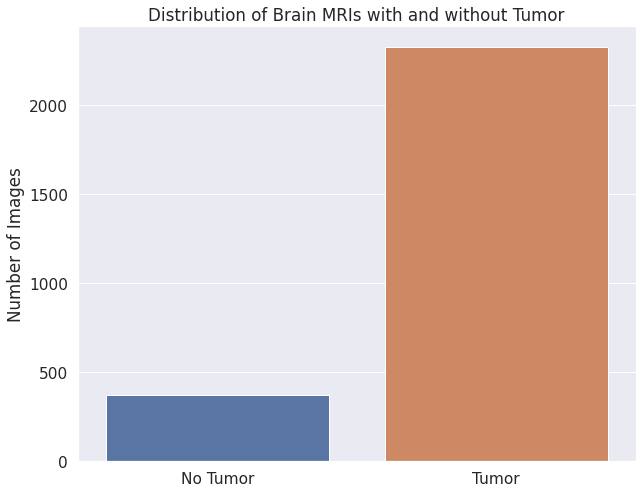

In [ ]:
# Barplot for visually assessing the training data class imbalance
plt.figure(figsize=(10,8))
sns.set(font_scale=1.4)
sns.barplot(['No Tumor', 'Tumor'], [train_no_tumor, train_tumor])
plt.ylabel("Number of Images")
plt.title('Distribution of Brain MRIs with and without Tumor');

**Now taking a look at the test data imbalance**

In [ ]:
# Making a DataFrame of testing data labels
test_tumors = pd.DataFrame(test_generator.classes)
test_values = test_tumors.value_counts()
test_values

1    289
0    105
dtype: int64

**The ratio of images with tumors to those without is 289:105, or 2.75:1¶**

In [ ]:
# Making subsets of the dataframe for plotting purposes
test_tumors.rename(columns={0:'Tumor/No Tumor'}, inplace=True)
test_no_tumor = len(test_tumors[test_tumors['Tumor/No Tumor'] == 0])
test_tumor = len(test_tumors[test_tumors['Tumor/No Tumor'] == 1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


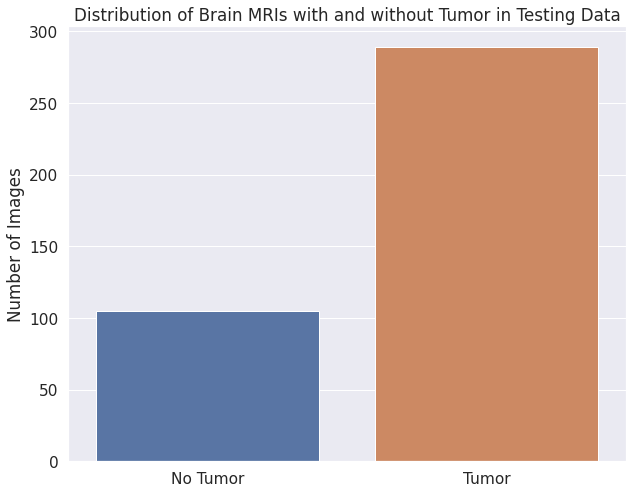

In [ ]:
# Barplot for visually assessing the class imbalance in the testing data
plt.figure(figsize=(10,8))
sns.set(font_scale=1.4)
sns.barplot(['No Tumor', 'Tumor'], [test_no_tumor, test_tumor])
plt.ylabel("Number of Images")
plt.title('Distribution of Brain MRIs with and without Tumor in Testing Data');

## **Baseline CNN Model**

In [ ]:
# Building the first baseline model; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
baseline = keras.Sequential()
baseline.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
baseline.add(layers.MaxPooling2D(2,2))
baseline.add(layers.Conv2D(64, (3,3), activation='relu'))
baseline.add(layers.MaxPooling2D(2,2))

baseline.add(layers.Flatten())
baseline.add(layers.Dense(128, activation='relu'))
baseline.add(layers.Dense(1, activation='sigmoid'))

baseline.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

In [ ]:
# Has been rerun
# Info for how to construct steps_per_epoch value from:
# https://stackoverflow.com/questions/46010565/checking-validation-results-in-keras-shows-only-50-correct-clearly-random
baseline_results = baseline.fit(x=train_img, y=train_lab,
                                          batch_size = 32,
                                         steps_per_epoch=2699 // 32 +1,# number of samples / batch size plus one, so that every batch is included
                                         epochs=10,
                                        validation_data= (test_img, test_lab),
                                         validation_steps= 394 // 32+1)

Epoch 1/10
85/85 [==============================] - 3s 34ms/step - loss: 3.2495e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - true_positives: 2327.0000 - true_negatives: 372.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - val_loss: 1.5113 - val_acc: 0.7132 - val_recall: 0.7543 - val_precision: 0.8385 - val_true_positives: 218.0000 - val_true_negatives: 63.0000 - val_false_positives: 42.0000 - val_false_negatives: 71.0000
Epoch 2/10
85/85 [==============================] - 3s 32ms/step - loss: 2.3135e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - true_positives: 2327.0000 - true_negatives: 372.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - val_loss: 1.5314 - val_acc: 0.7234 - val_recall: 0.7716 - val_precision: 0.8383 - val_true_positives: 223.0000 - val_true_negatives: 62.0000 - val_false_positives: 43.0000 - val_false_negatives: 66.0000
Epoch 3/10
85/85 [==============================] - 3s 33ms/step - loss: 1.8088e-04 - acc:

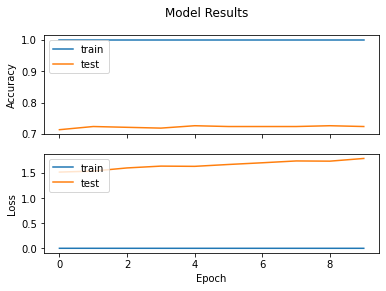

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(baseline_results)

**Analysis of Model**
 
In the last epoch, the training accuracy is 100% and testing accuracy is around 70%, with a training loss of 0% and a testing loss of around 170%. Testing recall is 77% and testing precision is 84%. Obviously, the model is overfitting, and loss is quite high; the recall score is low as well. In the next model iteration, I will add some dropout layers as a form of regularization.

## **Adding Dropout layers**

In [ ]:
# Adding another dense layer and a couple of dropout layers; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
drop = keras.Sequential()
drop.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
drop.add(layers.MaxPooling2D(2,2))
drop.add(layers.Conv2D(64, (3,3), activation='relu'))
drop.add(layers.MaxPooling2D(2,2))

drop.add(layers.Flatten())
drop.add(layers.Dense(128, activation='relu'))
drop.add(layers.Dropout(0.3))
drop.add(layers.Dense(1, activation='sigmoid'))

drop.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

In [ ]:
# Info for how to construct steps_per_epoch value from:
# https://stackoverflow.com/questions/46010565/checking-validation-results-in-keras-shows-only-50-correct-clearly-random
# Fitting the model
drop_results = drop.fit(x=train_img, y=train_lab,
                        batch_size = 32,
                        steps_per_epoch=2699 // 32+1,# number of samples / batch size + 1
                        epochs=10,
                        validation_data= (test_img, test_lab),
                        validation_steps= 394 // 32+1)

Epoch 1/10
85/85 [==============================] - 49s 43ms/step - loss: 0.4553 - acc: 0.8570 - recall: 0.9918 - precision: 0.8628 - true_positives: 2308.0000 - true_negatives: 5.0000 - false_positives: 367.0000 - false_negatives: 19.0000 - val_loss: 0.5707 - val_acc: 0.7234 - val_recall: 0.9758 - val_precision: 0.7344 - val_true_positives: 282.0000 - val_true_negatives: 3.0000 - val_false_positives: 102.0000 - val_false_negatives: 7.0000
Epoch 2/10
85/85 [==============================] - 3s 32ms/step - loss: 0.2702 - acc: 0.8914 - recall: 0.9841 - precision: 0.8995 - true_positives: 2290.0000 - true_negatives: 116.0000 - false_positives: 256.0000 - false_negatives: 37.0000 - val_loss: 0.6174 - val_acc: 0.6599 - val_recall: 0.6990 - val_precision: 0.8112 - val_true_positives: 202.0000 - val_true_negatives: 58.0000 - val_false_positives: 47.0000 - val_false_negatives: 87.0000
Epoch 3/10
85/85 [==============================] - 3s 32ms/step - loss: 0.1946 - acc: 0.9181 - recall: 0.9811

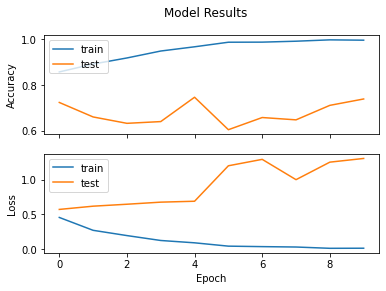

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(drop_results)

**Analysis of Model**

In this iteration, training accuracy ends up at 100%, and testing ends up at 80%, so the model is still overfitting. As for loss, training loss is 1% and testing loss is over 100%. Testing recall is 86% and testing precision is 80%. In the next model iteration I am going to account for the class imabalance, and the added layer and dropout layers might perform better in this iteration.

## **Accounting for Class Imbalance**

In [ ]:
# Accounting for class imbalance; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

class_ld = keras.Sequential()
class_ld.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
class_ld.add(layers.MaxPooling2D(2,2))
class_ld.add(layers.Conv2D(64, (3,3), activation='relu'))
class_ld.add(layers.MaxPooling2D(2,2))

class_ld.add(layers.Flatten())
class_ld.add(layers.Dense(128, activation='relu'))
class_ld.add(layers.Dropout(0.3))
class_ld.add(layers.Dense(1, activation='sigmoid'))

class_ld.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
weights = {0: 6.255, # NO TUMOR
          1: 1.} #  TUMOR 
# there are 6.255 times as many images of MRIs with tumors than without

In [ ]:
# has been rerun
# Fitting the model
class_ld_results = class_ld.fit(x=train_img, y=train_lab,
                                batch_size=32,
                                class_weight=weights,
                                steps_per_epoch=2699//32+1,# number of samples / batch size + 1
                                epochs=10,
                                validation_data=(test_img, test_lab),
                                validation_steps=394//32+1)

Epoch 1/10
85/85 [==============================] - 6s 51ms/step - loss: 1.7275 - acc: 0.2545 - recall: 0.1620 - precision: 0.8588 - true_positives: 377.0000 - true_negatives: 310.0000 - false_positives: 62.0000 - false_negatives: 1950.0000 - val_loss: 0.7038 - val_acc: 0.3401 - val_recall: 0.2180 - val_precision: 0.6495 - val_true_positives: 63.0000 - val_true_negatives: 71.0000 - val_false_positives: 34.0000 - val_false_negatives: 226.0000
Epoch 2/10
85/85 [==============================] - 3s 32ms/step - loss: 1.1003 - acc: 0.5287 - recall: 0.4912 - precision: 0.9285 - true_positives: 1143.0000 - true_negatives: 284.0000 - false_positives: 88.0000 - false_negatives: 1184.0000 - val_loss: 0.8767 - val_acc: 0.3629 - val_recall: 0.1557 - val_precision: 0.8654 - val_true_positives: 45.0000 - val_true_negatives: 98.0000 - val_false_positives: 7.0000 - val_false_negatives: 244.0000
Epoch 3/10
85/85 [==============================] - 3s 33ms/step - loss: 0.8190 - acc: 0.7970 - recall: 0.79

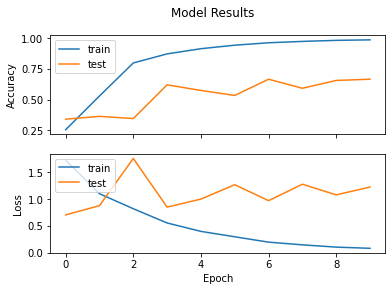

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(class_ld_results)

**Analysis of Model**

In this model iteration, training accuracy was about 98% and testing accuracy is about 67%, so the model is still overfitting, more so than in the last model. Loss for training is at around 8% and testing loss is around 120%. Testing recall is 60% and testing precision is 86%; it is clear that accounting for class imbalance in this way did not improve the model. Further research lead me to a [great article](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/), which discusses how class weights should be calculated. It mentions how adding too much weight to the minority class can sometimes cause the model to show a bias towards it, getting more images in the majority class wrong and making the model less robust. The calculation for what weight to put on the minority class is: total # samples / (2 * number of samples in the minority class). This calculation applied to the training data samples is as follows: 2870/(2*395), which comes out to be about 3.63. So, the class weight for the minority class, in this case "no_tumor" MRIs, should be close to 3.63. In the next model, I will see if a class weight of three applied to the no tumor images will be beneficial.

## **Adjusting Class Weights of Previous Model**

In [ ]:
# Accounting for class imbalance; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

adjclass_ld = keras.Sequential()
adjclass_ld.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
adjclass_ld.add(layers.MaxPooling2D(2,2))
adjclass_ld.add(layers.Conv2D(64, (3,3), activation='relu'))
adjclass_ld.add(layers.MaxPooling2D(2,2))

adjclass_ld.add(layers.Flatten())
adjclass_ld.add(layers.Dense(128, activation='relu'))
adjclass_ld.add(layers.Dropout(0.3))
adjclass_ld.add(layers.Dense(1, activation='sigmoid'))

adjclass_ld.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
# Incorporating adjusted class weights; compiling and fitting the model
weights3 = {0: 3, # NO TUMOR
          1:1.} # TUMOR 
# there are 6.255 times as many images of MRIs with tumors than without, but acording to the class weight calculation, I should 
# use a number close to 3.63 for the minority class, in this case the no tumor, or "zero" class.

In [ ]:
# has been rerun
# Fitting the model
adjclass_ld_results = adjclass_ld.fit(x=train_img, y=train_lab,
                                          class_weight=weights3,
                                         steps_per_epoch=2699//32+1,# number of samples / batch size + 1
                                         epochs=10,
                                         validation_data=(test_img, test_lab),
                                         validation_steps=394//32+1)

Epoch 1/10
85/85 [==============================] - 7s 48ms/step - loss: 0.9310 - acc: 0.7999 - recall: 0.8883 - precision: 0.8807 - true_positives: 2067.0000 - true_negatives: 92.0000 - false_positives: 280.0000 - false_negatives: 260.0000 - val_loss: 0.6327 - val_acc: 0.6802 - val_recall: 0.6886 - val_precision: 0.8468 - val_true_positives: 199.0000 - val_true_negatives: 69.0000 - val_false_positives: 36.0000 - val_false_negatives: 90.0000
Epoch 2/10
85/85 [==============================] - 3s 33ms/step - loss: 0.5319 - acc: 0.8811 - recall: 0.9287 - precision: 0.9331 - true_positives: 2161.0000 - true_negatives: 217.0000 - false_positives: 155.0000 - false_negatives: 166.0000 - val_loss: 0.7552 - val_acc: 0.6142 - val_recall: 0.6021 - val_precision: 0.8246 - val_true_positives: 174.0000 - val_true_negatives: 68.0000 - val_false_positives: 37.0000 - val_false_negatives: 115.0000
Epoch 3/10
85/85 [==============================] - 3s 33ms/step - loss: 0.3302 - acc: 0.9248 - recall: 0.

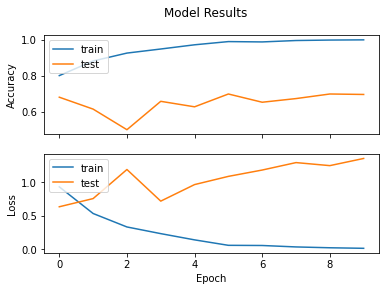

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(adjclass_ld_results)

**Analysis of model**

Training accuracy is 100% and testing accuracy is 70%, with a training loss of 1% and a testing loss of 130%. Testing recall is 74% and testing precision is 83%. The model is not much better, but since this is a better way to account for class weight I will keep these weights in the subsequent models. In the next iteration, I will try incorporating Batch Normalization, as this standardizes the input to each layer, and has the potential to decrease the potential to decrease the number of required training epochs to get optimal weights, according to [this article](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/#:~:text=Batch%20normalization%20is%20a%20technique,required%20to%20train%20deep%20networks.).

## **Summary of Models Not Included in this Notebook**

After this model iteration, I tried three more iterations. For the sake of making this final notebook a bit more concise, they are now located in a notebook called called ["All_Models_for_Binary_Brain_Tumor_Classification.ipynb"](https://github.com/brooke57/BrainTumorImageClassification/blob/main/Supplemental_Notebooks/All_Models_for_Binary_Brain_Tumor_Classification.ipynb). I will give a brief summary of these models here. 

In the next iteration, I tried adding another Convolutional Layer. The last epoch of training this model had a training accuracy of 92% and a testing accuracy of 59%, with a training loss of 33% and a testing loss of 83%. Testing recall is 51% and testing precision is 89%. Adding another convolution layer did not seem to improve the network results. However, I ended up keeping this layer and making additional adjustments to see if the extra convolutional layer together with other adjustmets would produce a more robust model. 

In the next iteration, I tried adjusting the size of the MaxPooling2D kernel. In all iterations up to this point I had always used a 2X2 kernel window after every convolution, but I wanted to see if increasing the kernel size after every additional convolution would help the network pick up on more patterns. In this iteration, the last epoch has a training accuracy of 93% and a testing accuracy of 48%, with a training loss of 29% and a testing loss of 107%. Testing recall was 31% and testing precision was 95%. Testing accuracy and loss had increased compared to the last model, so I decided that the original pooling strategy was best. 

In the next iteration, I tried introducing padding into each convolutional layer. The last epoch of this iteration had a training accuracy of 93% and a testing accuracy of 61%, with a training loss of 30% and a testing loss of 71%. Testing recall was 56%, testing precision was 98%. Testing accuracy and loss were better than in the last model iteration, but the results still weren't great. So, I decided to take out the padding and try Batch Normalization next.

## **Model with Batch Normalization**

In [ ]:
# Adding Batch Normalization; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
class_n = keras.Sequential()
class_n.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
class_n.add(layers.BatchNormalization())
class_n.add(layers.MaxPooling2D(2,2))
class_n.add(layers.Conv2D(64, (3,3), activation='relu'))
class_n.add(layers.BatchNormalization())
class_n.add(layers.MaxPooling2D(2,2))
class_n.add(layers.Conv2D(128, (3,3), activation='relu'))
class_n.add(layers.BatchNormalization())
class_n.add(layers.MaxPooling2D(2,2))

class_n.add(layers.Flatten())
class_n.add(layers.Dense(128, activation='relu'))
class_n.add(layers.Dropout(0.3))
class_n.add(layers.Dense(1, activation='sigmoid'))

class_n.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
# Incorporating adjusted class weights; compiling and fitting the model
weights3 = {0: 3, # NO TUMOR
          1:1.} # TUMOR 
# there are 6.255 times as many images of MRIs with tumors than without, but acording to the class weight calculation, I should 
# use a number close to 3.63 for the minority class, in this case the no tumor, or "zero" class.

In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop_bn1 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='bn_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
class_n_results = class_n.fit(x=train_img, y=train_lab,
                              batch_size = 32,
                              class_weight=weights3,
                              steps_per_epoch=2699//32+1,# number of samples / batch size + 1
                              epochs=20,
                              callbacks=early_stop_bn1,
                              validation_data=(test_img, test_lab),
                              validation_steps=394//32+1)

Epoch 1/20
85/85 [==============================] - 7s 59ms/step - loss: 4.9728 - acc: 0.7581 - recall: 0.7920 - precision: 0.9160 - true_positives: 1843.0000 - true_negatives: 203.0000 - false_positives: 169.0000 - false_negatives: 484.0000 - val_loss: 4.2148 - val_acc: 0.7335 - val_recall: 1.0000 - val_precision: 0.7335 - val_true_positives: 289.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 105.0000 - val_false_negatives: 0.0000e+00
Epoch 2/20
85/85 [==============================] - 4s 41ms/step - loss: 0.6994 - acc: 0.8518 - recall: 0.8844 - precision: 0.9402 - true_positives: 2058.0000 - true_negatives: 241.0000 - false_positives: 131.0000 - false_negatives: 269.0000 - val_loss: 8.7274 - val_acc: 0.7335 - val_recall: 1.0000 - val_precision: 0.7335 - val_true_positives: 289.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 105.0000 - val_false_negatives: 0.0000e+00
Epoch 3/20
85/85 [==============================] - 4s 46ms/step - loss: 0.5546 - acc: 0.875

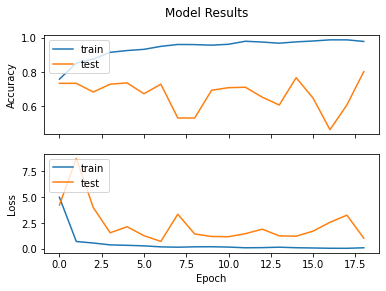

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(class_n_results)

**Analysis of Model**

 In the epoch with the lowest testing loss, training accuracy is 100% and testing accuracy is 73%, with a training loss of 9% and a testing loss of 71%. Testing recall is 76% and testing precision is 86%. This model yielded the lowest testing loss yet, so I will keep incorporating it in future iterations.
 Because batch normalization makes the network more stable, it is possible to use larger learning rates, which could potentially help the model reach optimal accuracy and minimal loss more quickly, so that is what I will try next.

## **Using a Bigger Learning Rate since I am using Batch Normalization**

In [ ]:
# Establishing an instance of Adam with a bigger learning rate
adam_mlr = keras.optimizers.Adam(epsilon=0.01)

In [ ]:
# Using Batch Normalization; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
class_na = keras.Sequential()
class_na.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
class_na.add(layers.BatchNormalization())
class_na.add(layers.MaxPooling2D(2,2))
class_na.add(layers.Conv2D(64, (3,3), activation='relu'))
class_na.add(layers.BatchNormalization())
class_na.add(layers.MaxPooling2D(2,2))
class_na.add(layers.Conv2D(128, (3,3), activation='relu'))
class_na.add(layers.BatchNormalization())
class_na.add(layers.MaxPooling2D(2,2))

class_na.add(layers.Flatten())
class_na.add(layers.Dense(128, activation='relu'))
class_na.add(layers.Dropout(0.3))
class_na.add(layers.Dense(1, activation='sigmoid'))

class_na.compile(loss='binary_crossentropy',
                optimizer=adam_mlr,
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
# Incorporating adjusted class weights; compiling and fitting the model
weights3 = {0: 3, # NO TUMOR
          1:1.} # TUMOR 
# there are 6.255 times as many images of MRIs with tumors than without, but acording to the class weight calculation, I should 
# use a number close to 3.63 for the minority class, in this case the no tumor, or "zero" class.

In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop_bl1 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='bl_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
# Using a bigger learning rate; fitting the model
class_na_results = class_na.fit(x=train_img, y=train_lab,
                                batch_size=32,
                                class_weight=weights3,
                                steps_per_epoch=2699//32,# number of samples / batch size + 1
                                epochs=20,
                                callbacks=early_stop_bl1,
                                validation_data=(test_img, test_lab),
                                validation_steps=394//32)

Epoch 1/20
84/84 [==============================] - 7s 63ms/step - loss: 0.9261 - acc: 0.8021 - recall: 0.8408 - precision: 0.9228 - true_positives: 1949.0000 - true_negatives: 207.0000 - false_positives: 163.0000 - false_negatives: 369.0000 - val_loss: 1.4848 - val_acc: 0.3490 - val_recall: 0.1879 - val_precision: 0.7162 - val_true_positives: 53.0000 - val_true_negatives: 81.0000 - val_false_positives: 21.0000 - val_false_negatives: 229.0000
Epoch 2/20
84/84 [==============================] - 4s 45ms/step - loss: 0.4561 - acc: 0.8909 - recall: 0.9167 - precision: 0.9552 - true_positives: 2112.0000 - true_negatives: 264.0000 - false_positives: 99.0000 - false_negatives: 192.0000 - val_loss: 1.0554 - val_acc: 0.7188 - val_recall: 0.9184 - val_precision: 0.7529 - val_true_positives: 259.0000 - val_true_negatives: 17.0000 - val_false_positives: 85.0000 - val_false_negatives: 23.0000
Epoch 3/20
84/84 [==============================] - 4s 45ms/step - loss: 0.3342 - acc: 0.9134 - recall: 0.9

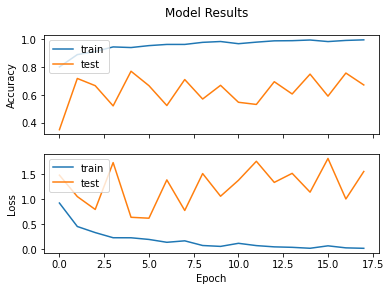

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(class_na_results)

**Analysis of Model**

In the epoch with the lowest testing loss, training accuracy is 91% while testing accuracy is 67%. Training loss is 33%, while testing loss is 80%. Testing recall is 79% and testing precision is 76%. Testing loss is greater than in the last model, so it looks like using a bigger learning rate is not advisable.

## **Model with Batch Normalization and more Dropout Layers**

In [ ]:
# Using Batch normalization with more layers; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
class_nd = keras.Sequential()

class_nd.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
class_nd.add(layers.BatchNormalization())
class_nd.add(layers.MaxPooling2D(2,2))
class_nd.add(layers.Dropout(0.25))

class_nd.add(layers.Conv2D(64, (3,3), activation='relu'))
class_nd.add(layers.BatchNormalization())
class_nd.add(layers.MaxPooling2D(2,2))
class_nd.add(layers.Dropout(0.25))

class_nd.add(layers.Conv2D(128, (3,3), activation='relu'))
class_nd.add(layers.BatchNormalization())
class_nd.add(layers.MaxPooling2D(2,2))
class_nd.add(layers.Dropout(0.25))

class_nd.add(layers.Flatten())
class_nd.add(layers.Dense(128, activation='relu'))
class_nd.add(layers.Dropout(0.4))
class_nd.add(layers.Dense(1, activation='sigmoid'))

class_nd.compile(loss='binary_crossentropy',
                optimizer= 'adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
# Incorporating adjusted class weights; compiling and fitting the model
weights3 = {0: 3, # NO TUMOR
          1:1.} # TUMOR 
# there are 6.255 times as many images of MRIs with tumors than without, but acording to the class weight calculation, I should 
# use a number close to 3.63 for the minority class, in this case the no tumor, or "zero" class.

In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop_bnd = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='bnd_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
# Fitting the model
class_nd_results = class_nd.fit(x=train_img, y=train_lab,
                                batch_size=32,
                                class_weight=weights3,
                                steps_per_epoch=2699//32+1,# number of samples / batch size + 1
                                epochs=20,
                                callbacks=early_stop_bnd,
                                validation_data=(test_img, test_lab),
                                validation_steps=394//32+1)

Epoch 1/20
85/85 [==============================] - 7s 58ms/step - loss: 5.9784 - acc: 0.7707 - recall: 0.8225 - precision: 0.9028 - true_positives: 1914.0000 - true_negatives: 166.0000 - false_positives: 206.0000 - false_negatives: 413.0000 - val_loss: 5.3263 - val_acc: 0.7335 - val_recall: 1.0000 - val_precision: 0.7335 - val_true_positives: 289.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 105.0000 - val_false_negatives: 0.0000e+00
Epoch 2/20
85/85 [==============================] - 4s 44ms/step - loss: 0.9786 - acc: 0.8425 - recall: 0.9162 - precision: 0.9026 - true_positives: 2132.0000 - true_negatives: 142.0000 - false_positives: 230.0000 - false_negatives: 195.0000 - val_loss: 11.3352 - val_acc: 0.7335 - val_recall: 1.0000 - val_precision: 0.7335 - val_true_positives: 289.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 105.0000 - val_false_negatives: 0.0000e+00
Epoch 3/20
85/85 [==============================] - 4s 44ms/step - loss: 0.6611 - acc: 0.85

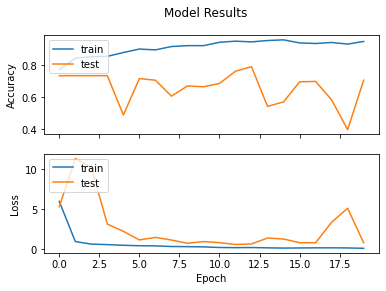

In [ ]:

# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(class_nd_results)

**Analysis of Model**

Training accuracy of the epoch with the lowest loss is 95% while testing accuracy is 76%. Training loss is 22% while testing loss is 62%. Testing recall is 81% and testing precision is 86%. Testing loss has decreased, so it looks like the added dropout layers are beneficial.

## **Transfer Learning: Using the Pre-Trained VGG-19 Weights**

In [ ]:
# Instantiating the pretrained VGG-19 model
from keras.applications.vgg19 import VGG19
cnn_vgg = VGG19(weights='imagenet',
               include_top=False,
               input_shape=(200,200,3))

80150528/80134624 [==============================] - 0s 0us/step


### 1. First Transfer Learning Iteration

In [ ]:
# Build first model using pretrained VGG 19 as first layer, and then some dense layers on top
pretrained = keras.Sequential()
pretrained.add(cnn_vgg)
pretrained.add(layers.Flatten())
pretrained.add(layers.Dense(128, activation='relu'))
pretrained.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Freezing the pretrained base
Freeze_Pretrained_Base(cnn_vgg, pretrained)

vgg19 False
flatten_12 True
dense_26 True
dense_27 True
4


In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop_pre1 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='pre1_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
# compiling and fitting the model
pretrained.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

pretrained_results = pretrained.fit(x=train_img, y=train_lab,
                                    batch_size = 32,
                                    steps_per_epoch=2699//32+1,# number of samples / batch size + 1
                                    epochs=20,
                                    callbacks= early_stop_pre1,
                                    validation_data=(test_img, test_lab),
                                    validation_steps=394//32+1)

Epoch 1/20
85/85 [==============================] - 16s 130ms/step - loss: 0.4558 - acc: 0.8629 - recall: 0.9506 - precision: 0.8966 - true_positives: 2212.0000 - true_negatives: 117.0000 - false_positives: 255.0000 - false_negatives: 115.0000 - val_loss: 0.4826 - val_acc: 0.7792 - val_recall: 0.8235 - val_precision: 0.8686 - val_true_positives: 238.0000 - val_true_negatives: 69.0000 - val_false_positives: 36.0000 - val_false_negatives: 51.0000
Epoch 2/20
85/85 [==============================] - 8s 92ms/step - loss: 0.1513 - acc: 0.9485 - recall: 0.9854 - precision: 0.9562 - true_positives: 2293.0000 - true_negatives: 267.0000 - false_positives: 105.0000 - false_negatives: 34.0000 - val_loss: 0.4045 - val_acc: 0.8173 - val_recall: 0.8789 - val_precision: 0.8729 - val_true_positives: 254.0000 - val_true_negatives: 68.0000 - val_false_positives: 37.0000 - val_false_negatives: 35.0000
Epoch 3/20
85/85 [==============================] - 7s 86ms/step - loss: 0.1102 - acc: 0.9600 - recall: 0

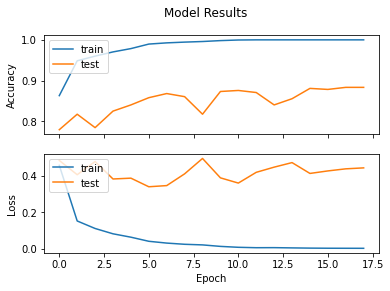

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(pretrained_results)

**Analysis of Model**

The epoch with the lowest testing loss has a training accuracy of 99% and a testing accuracy of 86%, with a training loss of 14% and a testing loss of 45%. Testing recall is 92%, and testing precision is 89%. Testing loss is much lower and testing accuracy is much higher than in the previous model, so using pretrianed models looks promising. In the next iteration, I will try fine tuning this network by adding dropout layers and unfreezing some of the outer layers of the pretrained network so they can learn from the images in this dataset.

## **2. Second Transfer Learning Iteration: Adding Dropout Layers and unfreezing outer layers**

In [ ]:
# Build first model using pretrained VGG 19 as first layer, and then some dense layers on top
b5c3c4_drop = keras.Sequential()
b5c3c4_drop.add(cnn_vgg)
b5c3c4_drop.add(layers.Dropout(0.4))
b5c3c4_drop.add(layers.Flatten())
b5c3c4_drop.add(layers.Dense(128, activation='relu'))
b5c3c4_drop.add(layers.Dropout(0.4))
b5c3c4_drop.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Unfreezing convolutional layers three and four
Freeze_Pretrained_Base(cnn_vgg, b5c3c4_drop)

vgg19 False
dropout_5 True
flatten_6 True
dense_12 True
dropout_6 True
dense_13 True
4


In [ ]:
# Looking at the layers in the pretrained VGG-19 network
cnn_vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
# Creating a list of layers to unfreeze
unfreeze2 = ['block5_conv3','block5_conv4']

In [ ]:
# Unfreezing some outer layers
Unfreeze_Layers(cnn_vgg, unfreeze2)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_conv4 True
block5_pool False
4


In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop_pre2 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='pre2_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
# Compiling and fitting the model
b5c3c4_drop.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

b5c3c4_drop_results = b5c3c4_drop.fit(x=train_img, y=train_lab,
                                      batch_size = 32,  
                                      steps_per_epoch=2699//32+1,# number of samples / batch size + 1
                                      epochs=32,
                                        callbacks= early_stop_pre2,
                                        validation_data=(test_img, test_lab),
                                        validation_steps=394//32+1)

Epoch 1/32
85/85 [==============================] - 10s 102ms/step - loss: 0.0698 - acc: 0.9692 - recall: 0.9824 - precision: 0.9820 - true_positives: 2286.0000 - true_negatives: 330.0000 - false_positives: 42.0000 - false_negatives: 41.0000 - val_loss: 0.7111 - val_acc: 0.8553 - val_recall: 0.8270 - val_precision: 0.9715 - val_true_positives: 239.0000 - val_true_negatives: 98.0000 - val_false_positives: 7.0000 - val_false_negatives: 50.0000
Epoch 2/32
85/85 [==============================] - 7s 86ms/step - loss: 0.0351 - acc: 0.9885 - recall: 0.9940 - precision: 0.9927 - true_positives: 2313.0000 - true_negatives: 355.0000 - false_positives: 17.0000 - false_negatives: 14.0000 - val_loss: 1.0056 - val_acc: 0.8832 - val_recall: 0.8858 - val_precision: 0.9517 - val_true_positives: 256.0000 - val_true_negatives: 92.0000 - val_false_positives: 13.0000 - val_false_negatives: 33.0000
Epoch 3/32
85/85 [==============================] - 8s 92ms/step - loss: 0.1093 - acc: 0.9763 - recall: 0.985

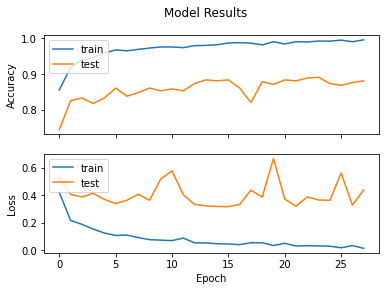

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(b5c3c4_drop_results)

**Analysis of Model**

The epoch with the lowest testing loss has a training acuracy of 99% and a testing accuracy of 88%, with a training loss of 4% and a testing loss of 32%. Testing recall is 89% and testing precision is 94%. This model is performing better than the last pretrained model with all layers frozen and no dropout layers, but I want to see how model performs with all layers frozen but including dropout layers.

## **3. Third Transfer Learning Iteration: Freezing all Layers, just including one dropout layer**

In [ ]:
# Build first model using pretrained VGG 19 as first layer, and then some dense layers on top
pre_drop = keras.Sequential()
pre_drop.add(cnn_vgg)
pre_drop.add(layers.Flatten())
pre_drop.add(layers.Dense(128, activation='relu'))
pre_drop.add(layers.Dropout(0.4))
pre_drop.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Freezing all layers in pretrained VGG-19 network
Freeze_Pretrained_Base(cnn_vgg, pre_drop)

vgg19 False
flatten_1 True
dense_2 True
dropout_1 True
dense_3 True
4


In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop_pre3 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='pre3_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
# Compiling and fitting the model
pre_drop.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

pre_drop_results = pre_drop.fit(x=train_img, y=train_lab,
                                steps_per_epoch=2699//32+1,# number of samples / batch size + 1
                                epochs=20,
                                callbacks= early_stop_pre3,
                                validation_data=(test_img, test_lab),
                                validation_steps=394//32+1)

Epoch 1/20
85/85 [==============================] - 25s 156ms/step - loss: 0.4430 - acc: 0.8740 - recall: 0.9549 - precision: 0.9044 - true_positives: 2222.0000 - true_negatives: 137.0000 - false_positives: 235.0000 - false_negatives: 105.0000 - val_loss: 0.4721 - val_acc: 0.7741 - val_recall: 0.8097 - val_precision: 0.8731 - val_true_positives: 234.0000 - val_true_negatives: 71.0000 - val_false_positives: 34.0000 - val_false_negatives: 55.0000
Epoch 2/20
85/85 [==============================] - 7s 87ms/step - loss: 0.1740 - acc: 0.9329 - recall: 0.9862 - precision: 0.9390 - true_positives: 2295.0000 - true_negatives: 223.0000 - false_positives: 149.0000 - false_negatives: 32.0000 - val_loss: 0.4202 - val_acc: 0.8122 - val_recall: 0.8581 - val_precision: 0.8826 - val_true_positives: 248.0000 - val_true_negatives: 72.0000 - val_false_positives: 33.0000 - val_false_negatives: 41.0000
Epoch 3/20
85/85 [==============================] - 7s 82ms/step - loss: 0.1522 - acc: 0.9415 - recall: 0

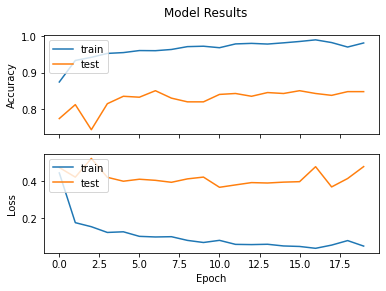

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(pre_drop_results)

**Analysis of Model**

The epoch with the lowest testing loss had a training accuracy of 97% and a testing accuracy of 84%, with a training loss of 8% and a testing loss of 37%. Testing recall is 84% and Testing precision is 92%. In terms of loss and accuracy, this iteration does not yield as good of results as in the last iteration. So, I will unfreeze outer layers again and will try incorporating class weights into pretrained network.

## **4. Fourth Model Iteration: Incorporating Class Weights into Pretrained VGG-19**

In [ ]:
# Build first model using pretrained VGG 19 as first layer, and then some dense layers on top
w3_b5c1c2 = keras.Sequential()
w3_b5c1c2.add(cnn_vgg)
w3_b5c1c2.add(layers.Dropout(0.4))
w3_b5c1c2.add(layers.Flatten())
w3_b5c1c2.add(layers.Dense(128, activation='relu'))
w3_b5c1c2.add(layers.Dropout(0.4))
w3_b5c1c2.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Freezing all layers in pretrained VGG-19 network
Freeze_Pretrained_Base(cnn_vgg, w3_b5c1c2)

vgg19 False
dropout_3 True
flatten_5 True
dense_10 True
dropout_4 True
dense_11 True
4


In [ ]:
Unfreeze_Layers(cnn_vgg, unfreeze2)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_conv4 True
block5_pool False
4


In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop2 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
# Incorporating adjusted class weights; compiling and fitting the model
weights3 = {0: 3, # NO TUMOR
          1:1.} # TUMOR 
# there are 6.255 times as many images of MRIs with tumors than without, but acording to the class weight calculation, I should 
# use a number close to 3.63 for the minority class, in this case the no tumor, or "zero" class.


w3_b5c1c2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

w3_b5c1c2_results = w3_b5c1c2.fit(x=train_img, y=train_lab,
                                  class_weight = weights3,
                                  batch_size = 32,
                                  steps_per_epoch=2699//32+1,# number of samples / batch size + 1
                                  epochs=20,
                                  callbacks= early_stop2,
                                  validation_data=(test_img, test_lab),
                                  validation_steps=394//32+1)

Epoch 1/20
85/85 [==============================] - 11s 114ms/step - loss: 0.1474 - acc: 0.9755 - recall: 0.9789 - precision: 0.9926 - true_positives: 2278.0000 - true_negatives: 355.0000 - false_positives: 17.0000 - false_negatives: 49.0000 - val_loss: 0.8754 - val_acc: 0.8249 - val_recall: 0.8062 - val_precision: 0.9472 - val_true_positives: 233.0000 - val_true_negatives: 92.0000 - val_false_positives: 13.0000 - val_false_negatives: 56.0000
Epoch 2/20
85/85 [==============================] - 8s 93ms/step - loss: 0.1338 - acc: 0.9796 - recall: 0.9815 - precision: 0.9948 - true_positives: 2284.0000 - true_negatives: 360.0000 - false_positives: 12.0000 - false_negatives: 43.0000 - val_loss: 0.7662 - val_acc: 0.8655 - val_recall: 0.8720 - val_precision: 0.9403 - val_true_positives: 252.0000 - val_true_negatives: 89.0000 - val_false_positives: 16.0000 - val_false_negatives: 37.0000
Epoch 3/20
85/85 [==============================] - 7s 88ms/step - loss: 0.0890 - acc: 0.9863 - recall: 0.98

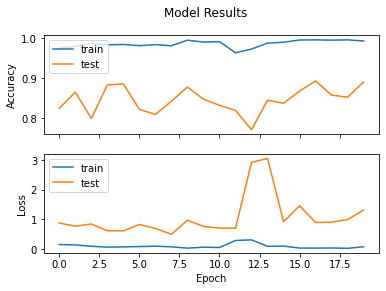

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(w3_b5c1c2_results)

**Analysis of Model**

The epoch with the lowest testing loss has a training accuracy of 98% and a testing accuracy of 84%, with a training loss of 7% and a testing loss of 49%. Testing recall is 81% and testing precision is 97%. This model performs worse than the previous two iterations.

## **Testing the Best Model**

From analyzing the different metrics such as loss, accuracy, recall, and precision, it is clear that the third transfer learning iteration has the best overall metrics. Overfitting has been greatly reduced, testing loss has been reduced considerably, and there is high recall and precision. Now it is time to evaluate the model on the validation hold-out set.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


Val Loss: 0.11886338889598846
Val Accuracy: 0.9532163739204407
Val Recall: 1.0
Val Precision: 0.9487179517745972
Val True Positives: 148.0
Val True Negatives: 15.0
Val False Positives: 8.0
Val False Negatives: 0.0


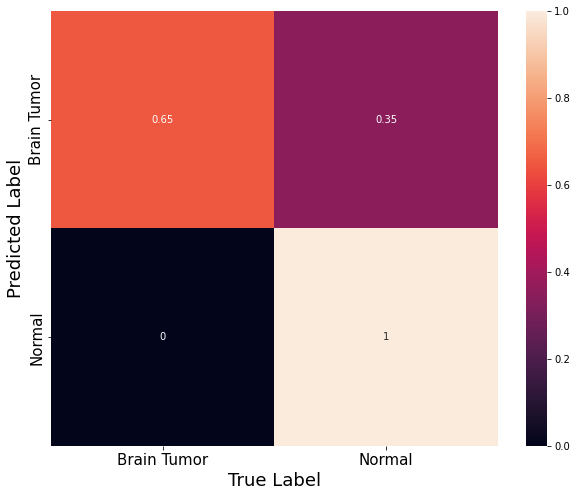

In [ ]:
print_metrics_confusionmatrix('pre3_best_model.h5', val_generator, 'Val')

**Analysis of using final model on Validation data**

When the final model was used to evaluate the validation data, it had excellent performance. Validation accuracy is 97%, with a loss of only 7%. The model has 100% recall, which means that it isn't failing to diagnose tumors when they appear in a MRI scan. This was our goal, so it is excellent that recall has been maximized!

## **Overall Conclusions**

Throughout this neural network modeling process, many different iterations were run. In the end, the iteration which yielded the best results was a pretrained VGG-19 network accounting for class weights (giving the minority class of "no tumor" images a weight of three) with a flatten layer and two dense layers on top, with all of the VGG-19 layers frozen. This model iteration had a validation accuracy of 97%, a loss of 7%, recall of 100%, and a precision of 97%. Because recall is 100%, no tumorous scans are slipping through the cracks, which means that patients' tumors will not go undiagnosed. Additionally, because precision is so high as well, the model will identify very few tumor free scans as containing a tumor. These results signify that this would be a powerful, reliable tool for helping to flag scans which have a tumor for further analysis and classification by a physician. In a developing nation with fewer seasoned physicians, who may still be learning to detect and diagnose tumors from an MRI, this would be especially valuable. Additionally, using this model could potentially cut down on the physician time required to analyze patient scans, potentially giving them more time and energy to focus on other patients, thereby improving health outcomes for all. All of these reasons support why this model would be of great benefit for *Doctors without Borders* as they improve the healthcare of developing nations.